In [20]:
import pandas as pd
import numpy as np
import xml.etree
import matplotlib.pyplot as plt
import seaborn as sns
from implementations import *
import csv
import gzip
import xml.etree.ElementTree as ET
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [2]:
df = pd.read_csv('characters_descriptions.csv')

In [14]:
## a description of the data frame
print('This dataframe contains all the actions associated with every character in every movie resumes. \nColumns about ids will be usefull for merging action with other dataframes.')
print('number of rows : ' + str(df.shape[0]))
df.sample(5)

this dataframe contains all the actions associated with every character in every movie resumes. 
Columns about ids will be usefull for merging action with other dataframes.
number of rows : 2561042


,actor name,actor id,actor gender,character name,dependency,governor,dependent,action,movie id
2191621,Jong-soo Kim,/m/0j135_s,M,North Korea defect executive,det,North,the,the,32364895
433051,Rina Hidaka,/m/0h6869m,F,Mana,conj_and,Asuna,Mana,Asuna,29542934
1514382,Jim Cummings,/m/02_p5w,M,Steele the Sled Dog,nsubj,Steele,which,which,1487971
1481406,Donna Murphy,/m/06bhxw,F,Rosalie Octavius,nsubj,uses,Octavius,uses,612052
691788,Saif Ali Khan,/m/05g3ss,M,Prince Harshwardhan,dobj,forgives,Harshwardhan,forgives,3030953


In [140]:
## in this study we are interested in actor's actions
## let's remove some irrelevant words that we found
irrelevant_words = ['\'s', 'and', 'with', 'of', 'to', 'by', 'for', 'the', 'in', 'is', 'has', 'from', 'as',
                   'his', 'on', 'Dr.', 'The', 'a', 'Mr.', 'John', 'Miss', 'Mrs.', 'father', 'son', 'friend', 
                   'daughter', 'wife', 'mother', 'family', 'sister', 'brother', 'man', 'men', 'Captain', 
                   'Singh', 'Jack', 'King', 'girl', 'woman', 'girlfriend', 'Mary', 'husband', 'parents', 
                   'Lady', 'children', 'White', 'Queen', 'car', 'room']

conditions = (df['action']!='')

for irr_wrd in irrelevant_words:
    conditions = conditions&(df['action']!=irr_wrd)
    
act_df_treated = df[conditions]

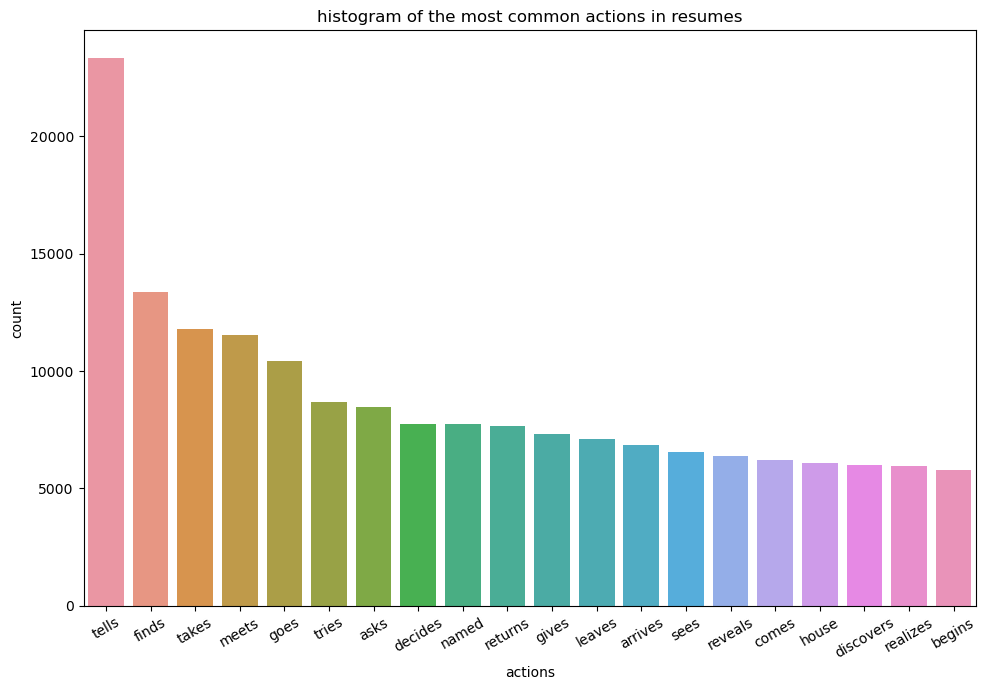

In [132]:
## let's have an overview of the most common actions of actors : 
most_common_actions = act_df_treated.groupby('action', as_index = False).count().sort_values('actor name', ascending = False).head(20)[['action', 'actor name']]
plt.figure(figsize = (10, 7))
sns.barplot(x= most_common_actions['action'], y = most_common_actions['actor name'])
plt.title('histogram of the most common actions in resumes')
plt.ylabel('count')
plt.xlabel('actions')
plt.xticks(rotation=30)
plt.tight_layout()

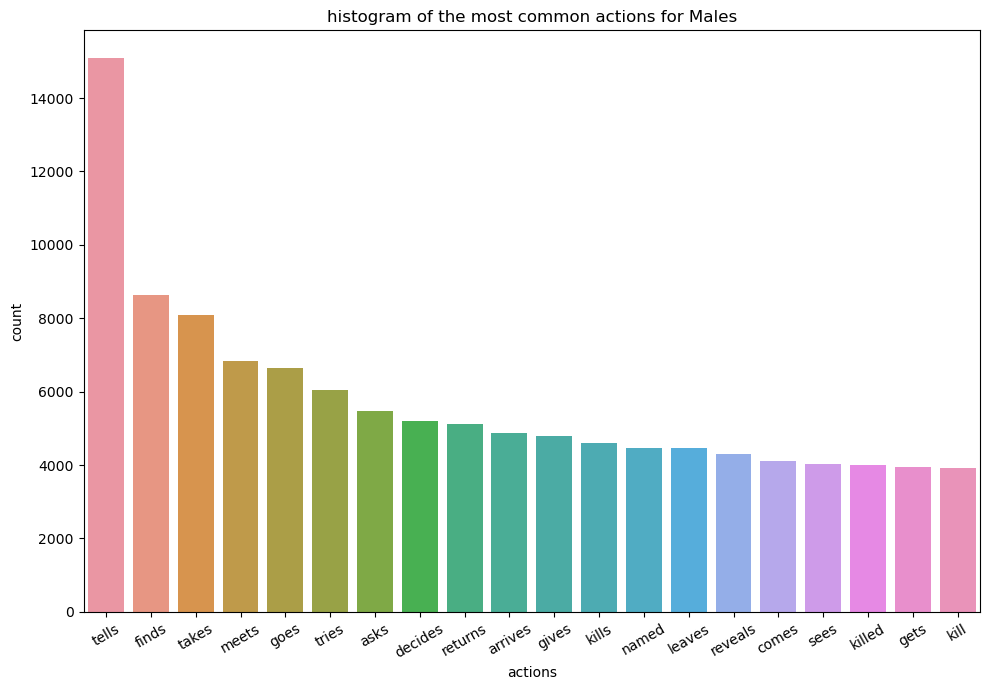

In [133]:
## now let's look at the same histogram, but this time only for mens
most_common_actions_M = act_df_treated[act_df_treated['actor gender']=='M'].groupby('action', as_index = False).count().sort_values('actor name', ascending = False).head(20)[['action', 'actor name']]
plt.figure(figsize = (10, 7))
sns.barplot(x= most_common_actions_M['action'], y = most_common_actions_M['actor name'])
plt.title('histogram of the most common actions for Males')
plt.ylabel('count')
plt.xlabel('actions')
plt.xticks(rotation=30)
plt.tight_layout()

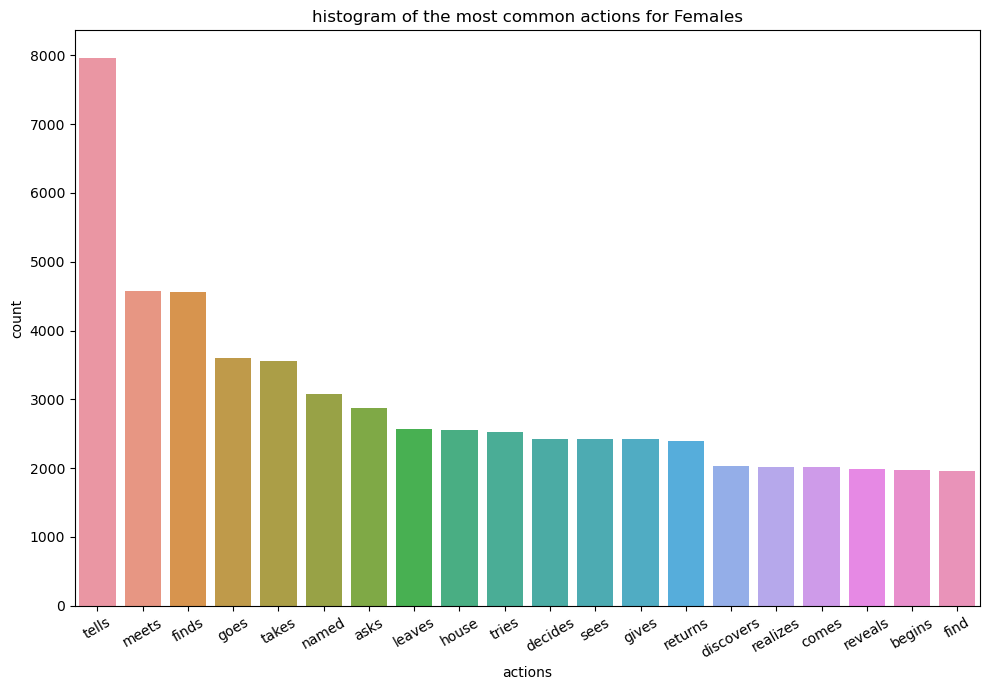

In [135]:
## and for women : 
most_common_actions_F = act_df_treated[act_df_treated['actor gender']=='F'].groupby('action', as_index = False).count().sort_values('actor name', ascending = False).head(20)[['action', 'actor name']]
plt.figure(figsize = (10, 7))
sns.barplot(x= most_common_actions_F['action'], y = most_common_actions_F['actor name'])
plt.title('histogram of the most common actions for Females')
plt.ylabel('count')
plt.xlabel('actions')
plt.xticks(rotation=30)
plt.tight_layout()

Looking at those graphs, it seems that there are a lot of words in common for both men and women.

In [136]:
## Now let's separate these two data sets and make some more comparisons
male_description = act_df_treated[act_df_treated['actor gender']=='M']
female_description = act_df_treated[act_df_treated['actor gender']=='F']

In [137]:
## let's take the 100 most common actions for males also for females
## We will look at actions that are common for both genders and the ones that are only 
## for on of them
head_males = male_description.groupby('action', as_index=False).count().sort_values('actor name', ascending = False).head(100)
head_females = female_description.groupby('action', as_index=False).count().sort_values('actor name', ascending = False).head(100)

Men and women share, over their 100 most common actions : 85 actions


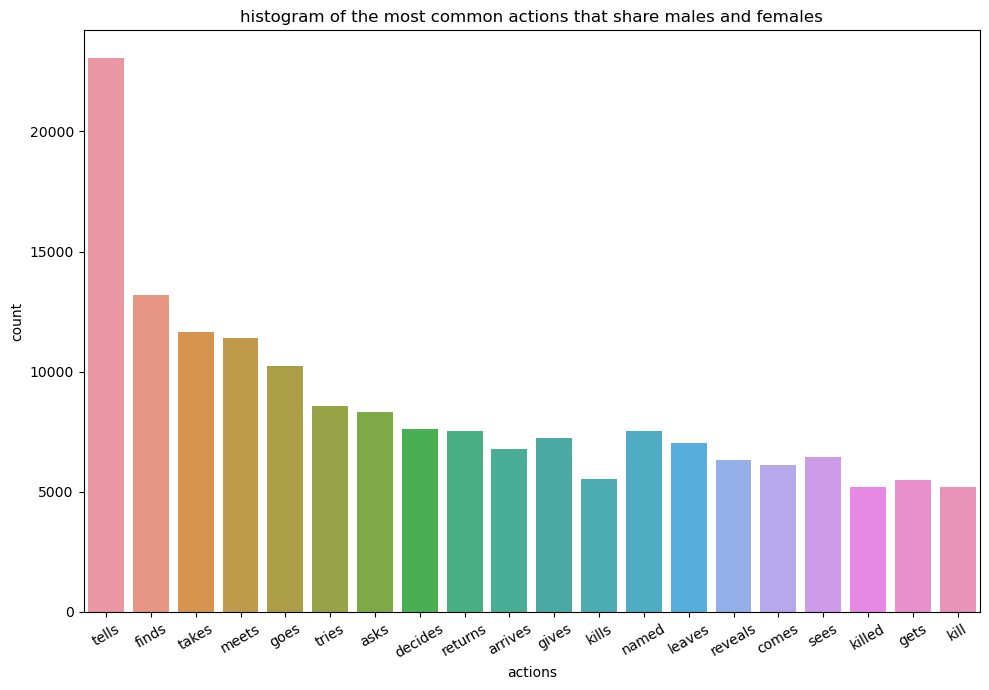

In [138]:
## we merge them on their common most common words :
merge_df = head_males.merge(head_females, how = 'inner', on = 'action', suffixes=('_M', '_F'))
plt.figure(figsize = (10, 7))
sns.barplot(x= merge_df.head(20)['action'], y = merge_df.head(20)['actor name_M']+merge_df.head(20)['actor name_F'])
plt.title('histogram of the most common actions that share males and females')
plt.ylabel('count')
plt.xlabel('actions')
plt.xticks(rotation=30)
plt.tight_layout()
## on the 100 most common actions for men and female, how many are shared by both gender ?
print('Men and women share, over their 100 most common actions : ' + str(merge_df.shape[0]) + ' actions')

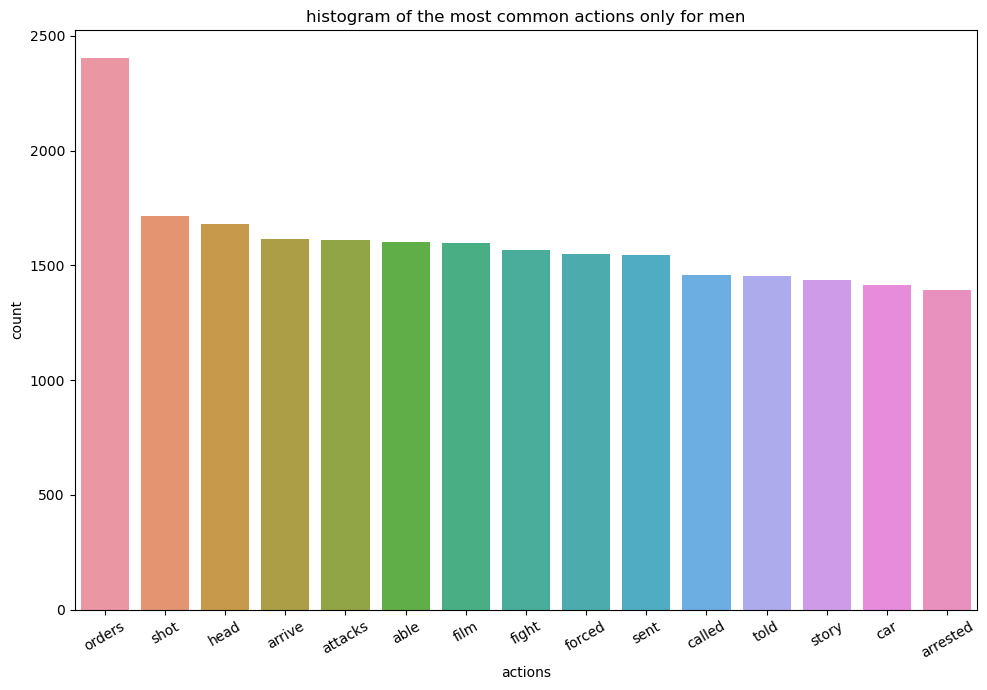

In [139]:
## now we look at the actions that males and females doesn't share
top_actions_M = pd.concat([head_males[['action', 'actor name']].rename(columns={'actor name': "actor name_M"}), merge_df[['action', 'actor name_M']], merge_df[['action', 'actor name_M']]]).drop_duplicates(keep=False)
plt.figure(figsize = (10, 7))
sns.barplot(x= top_actions_M.head(15)['action'], y = top_actions_M.head(15)['actor name_M'])
plt.title('histogram of the most common actions only for men')
plt.ylabel('count')
plt.xlabel('actions')
plt.xticks(rotation=30)
plt.tight_layout()


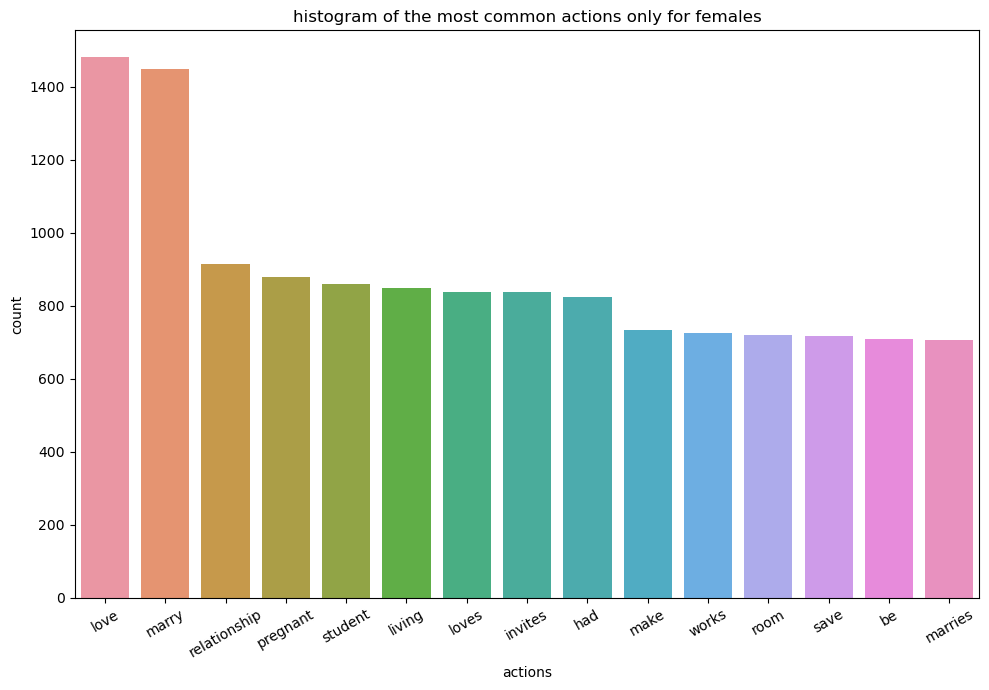

In [141]:
## and for women : 
top_actions_F = pd.concat([head_females[['action', 'actor name']].rename(columns={'actor name': "actor name_F"}), merge_df[['action', 'actor name_F']], merge_df[['action', 'actor name_F']]]).drop_duplicates(keep=False)
plt.figure(figsize = (10, 7))
sns.barplot(x= top_actions_F.head(15)['action'], y = top_actions_F.head(15)['actor name_F'])
plt.title('histogram of the most common actions only for females')
plt.ylabel('count')
plt.xlabel('actions')
plt.xticks(rotation=30)
plt.tight_layout()

Now that we see for all the movies the different actions for men and women. We also know that these actions are conditionned to the movie genre. 